<a href="https://colab.research.google.com/github/AmiraBelkis/PFE-TEST/blob/optimize-WT/Cifar-100/AG_SimpleCNN_Cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rssrc

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 13 20:22:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Lib

In [2]:
import random
import string
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import matplotlib.colors as colors
import numpy as np
from copy import deepcopy

In [3]:
import AG

100%|██████████| 169001437/169001437 [00:13<00:00, 12336883.78it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
import importlib
import global_param
importlib.reload(global_param)
importlib.reload(AG)

Files already downloaded and verified
Files already downloaded and verified


<module 'AG' from '/content/AG.py'>

# AG

In [ ]:
model_path = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Models/Cifar-100/SimpleCNN_cifar_100'
model_base = torch.load(model_path)

In [ ]:
AG.evaluation_2(model_base , nn.CrossEntropyLoss())

Accuracy: 29.54%
Loss: 3.3521


(0.2954, 3.3520571319920243)

## Fine-tune the base model


---
in case model accurancy is low. if the accurancy is not improving then try to adjust the learning rate (lr). if it didn't help then the model has reach its maximal accurancy use as it is


### Data augmentation

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import  CIFAR100

def load_cifar_100():
    # Define the data transformations
    data_transforms = {
        # use transforms.Compose to perform multiples transfomation at once
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=32, padding=4),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
        ]),
        'val': transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
        ]),
    }

    # Download and load the MNIST dataset
    train_dataset = CIFAR100(root='./data', train=True, transform=data_transforms['train'],download=True)
    test_dataset = CIFAR100(root='./data',  train=False, transform=data_transforms['val'],download=True)
    image_datasets ={
        'train':train_dataset,
        'val':test_dataset
    }
    # Create data loaders
    batch_size = 64
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
                        for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    return [dataloaders,dataset_sizes,class_names,device]


dataloaders,dataset_sizes,class_names,device = load_cifar_100()

Files already downloaded and verified
Files already downloaded and verified


### Training

In [ ]:
def train_model(model, criterion, optimizer, scheduler , num_epochs=7):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    statics = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            statics.append(
                {'epoch': epoch+1, 'phase': phase, 'acc': epoch_acc, 'loss': epoch_loss}
            )
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, statics

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv  =  optim.SGD(model_base.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)
model , statics = train_model(model_base, criterion , optimizer_conv , exp_lr_scheduler , 10)

Epoch 0/9
----------
train Loss: 3.6702 Acc: 0.1453
val Loss: 3.1877 Acc: 0.2321

Epoch 1/9
----------
train Loss: 3.4440 Acc: 0.1795
val Loss: 3.2393 Acc: 0.2249

Epoch 2/9
----------
train Loss: 3.3738 Acc: 0.1906
val Loss: 3.1640 Acc: 0.2395

Epoch 3/9
----------
train Loss: 3.3050 Acc: 0.2028
val Loss: 3.1053 Acc: 0.2423

Epoch 4/9
----------
train Loss: 3.2513 Acc: 0.2139
val Loss: 3.1101 Acc: 0.2421

Epoch 5/9
----------
train Loss: 3.0249 Acc: 0.2543
val Loss: 2.7796 Acc: 0.3092

Epoch 6/9
----------
train Loss: 2.9716 Acc: 0.2668
val Loss: 2.7774 Acc: 0.3117

Epoch 7/9
----------
train Loss: 2.9494 Acc: 0.2714
val Loss: 2.7498 Acc: 0.3137

Epoch 8/9
----------
train Loss: 2.9381 Acc: 0.2720
val Loss: 2.7440 Acc: 0.3199

Epoch 9/9
----------
train Loss: 2.9142 Acc: 0.2773
val Loss: 2.7177 Acc: 0.3233

Training complete in 28m 31s
Best val Acc: 0.323300


In [ ]:
torch.save(model,model_path)

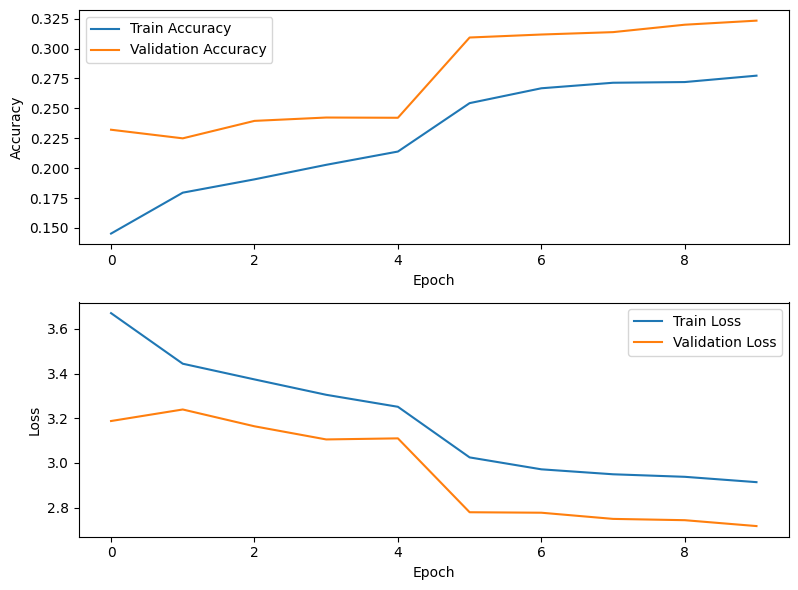

In [ ]:
AG.show_statics_training(statics, model_path + 'fine-tune 04(data augmentation)' )

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv  =  optim.SGD(model_base.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.2)
model , statics = train_model(model_base, criterion , optimizer_conv , exp_lr_scheduler , 15)

Epoch 0/14
----------
train Loss: 3.0309 Acc: 0.2529
val Loss: 2.8210 Acc: 0.3008

Epoch 1/14
----------
train Loss: 3.0078 Acc: 0.2578
val Loss: 2.7693 Acc: 0.3081

Epoch 2/14
----------
train Loss: 2.9860 Acc: 0.2610
val Loss: 2.8105 Acc: 0.3025

Epoch 3/14
----------
train Loss: 2.9658 Acc: 0.2680
val Loss: 2.7470 Acc: 0.3146

Epoch 4/14
----------
train Loss: 2.9361 Acc: 0.2703
val Loss: 2.7351 Acc: 0.3158

Epoch 5/14
----------
train Loss: 2.7927 Acc: 0.3012
val Loss: 2.6148 Acc: 0.3424

Epoch 6/14
----------
train Loss: 2.7585 Acc: 0.3069
val Loss: 2.5966 Acc: 0.3466

Epoch 7/14
----------
train Loss: 2.7398 Acc: 0.3110
val Loss: 2.5878 Acc: 0.3450

Epoch 8/14
----------
train Loss: 2.7315 Acc: 0.3111
val Loss: 2.6019 Acc: 0.3495

Epoch 9/14
----------
train Loss: 2.7200 Acc: 0.3150
val Loss: 2.5647 Acc: 0.3536

Epoch 10/14
----------
train Loss: 2.6818 Acc: 0.3213
val Loss: 2.5539 Acc: 0.3558

Epoch 11/14
----------
train Loss: 2.6806 Acc: 0.3229
val Loss: 2.5419 Acc: 0.3592

Ep

In [ ]:
torch.save(model,model_path)

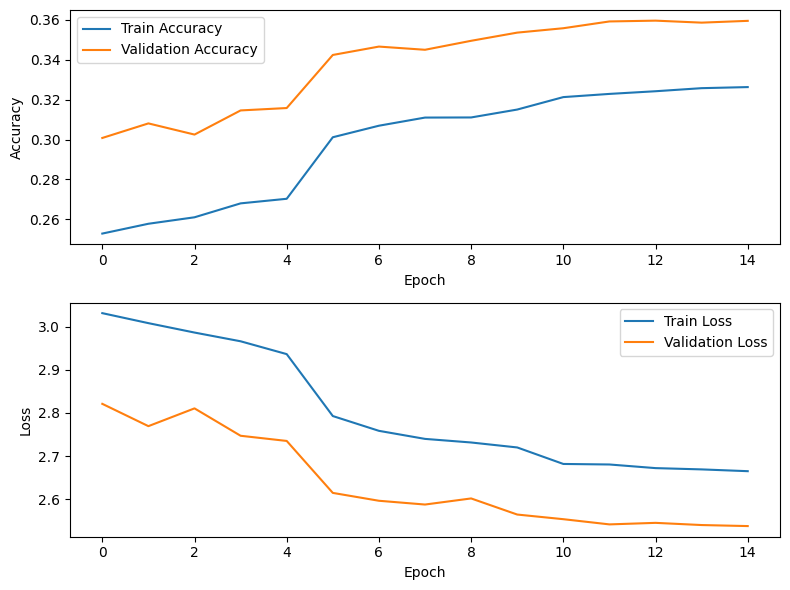

In [ ]:
AG.show_statics_training(statics, model_path + 'fine-tune 05(data augmentation 2nd itr)' )

In [ ]:
model_path = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Models/Cifar-100/SimpleCNN_cifar_100'
model_base = torch.load(model_path)

In [ ]:
AG.evaluation_2(model_base , nn.CrossEntropyLoss())

Accuracy: 35.96%
Loss: 2.5457


(0.3596, 2.5456785373627002)

## AG main method

In [ ]:
save_to = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Cifar-100/SimpleCNN/'
os.makedirs(save_to, exist_ok=True)
os.makedirs(save_to +'children/', exist_ok=True)
os.makedirs(save_to +'parents/', exist_ok=True)
os.makedirs(save_to +'kd/', exist_ok=True)
os.makedirs(save_to +'kd/training/', exist_ok=True)

Generating the initial population :
     - individual 0 ----------- 100%
     - individual 1 ----------- 100%
     - individual 2 ----------- 100%
     - individual 3 ----------- 100%
     - individual 4 ----------- 100%
     - individual 5 ----------- 100%
     - individual 6 ----------- 100%
     - individual 7 ----------- 100%
Performing KD on the initial population :
------------------------------ Training 1 ---------------------------------
Epoch 0/4
----------
train Loss: 1.7905 Acc: 0.0781
val Loss: 1.5637 Acc: 0.1214

Epoch 1/4
----------
train Loss: 1.5086 Acc: 0.1458
val Loss: 1.4635 Acc: 0.1525

Epoch 2/4
----------
train Loss: 1.4245 Acc: 0.1758
val Loss: 1.4001 Acc: 0.1752

Epoch 3/4
----------
train Loss: 1.3673 Acc: 0.2005
val Loss: 1.3461 Acc: 0.1950

Epoch 4/4
----------
train Loss: 1.3056 Acc: 0.2228
val Loss: 1.3002 Acc: 0.2117

Training complete in 11m 7s
Best val Acc: 0.211700
------------------------------ Training 2 ---------------------------------
Epoch 0/4
---

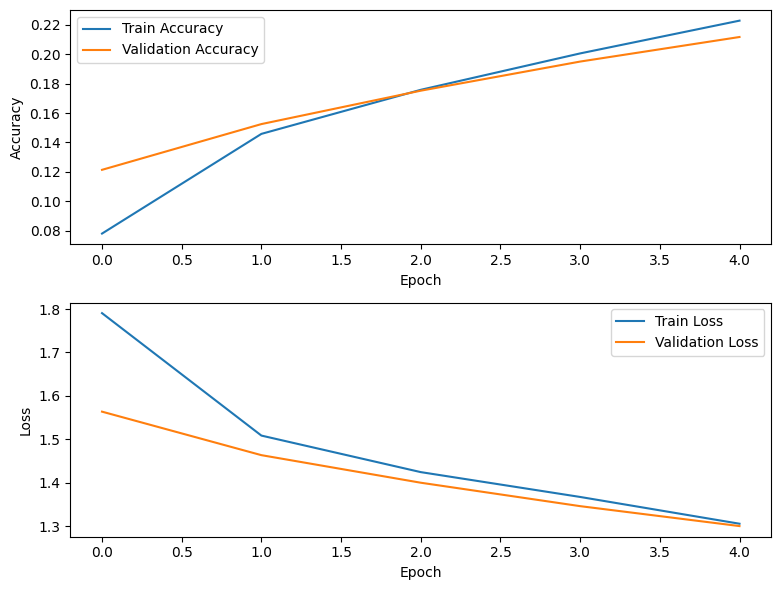

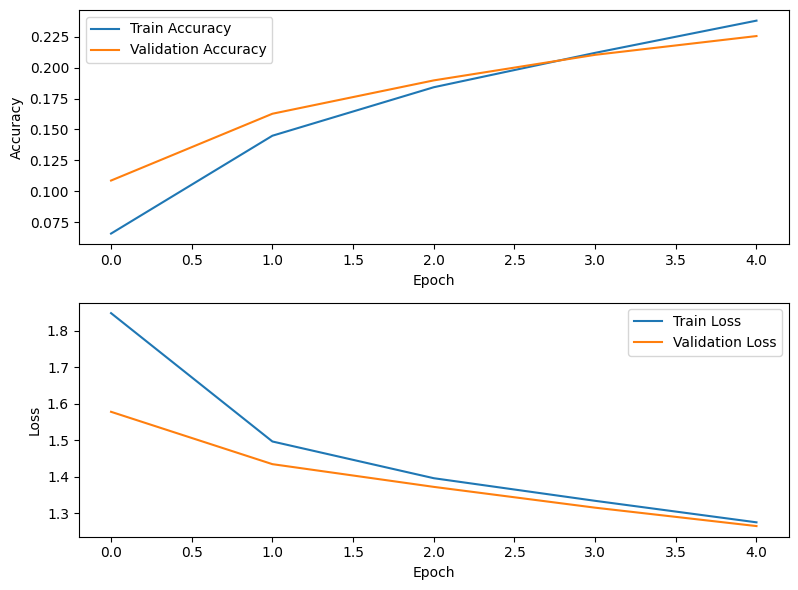

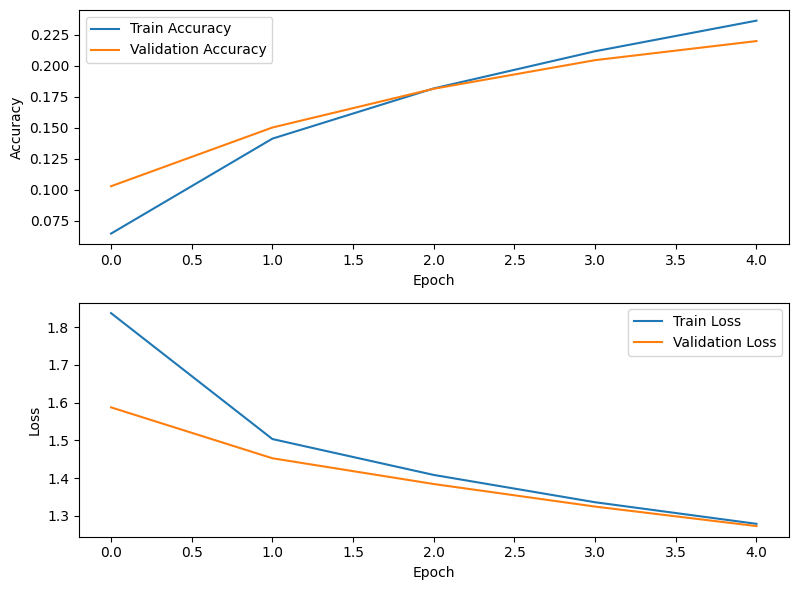

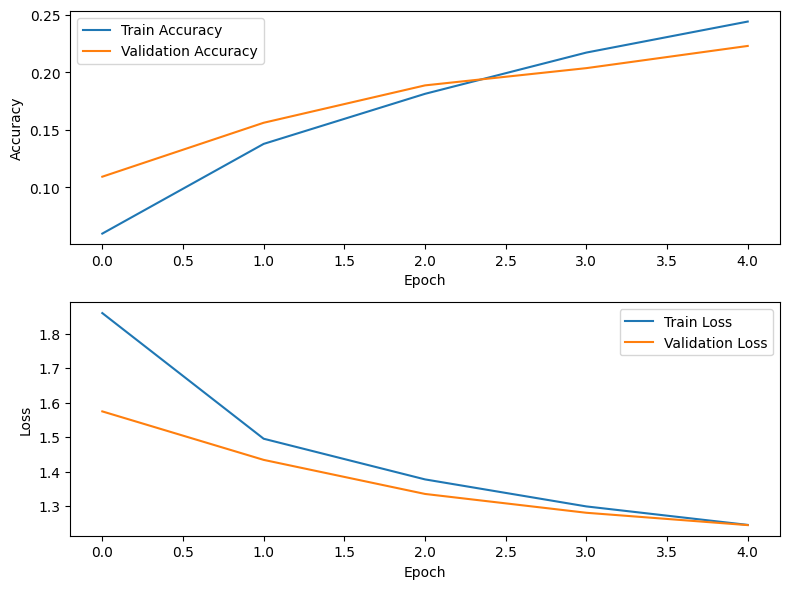

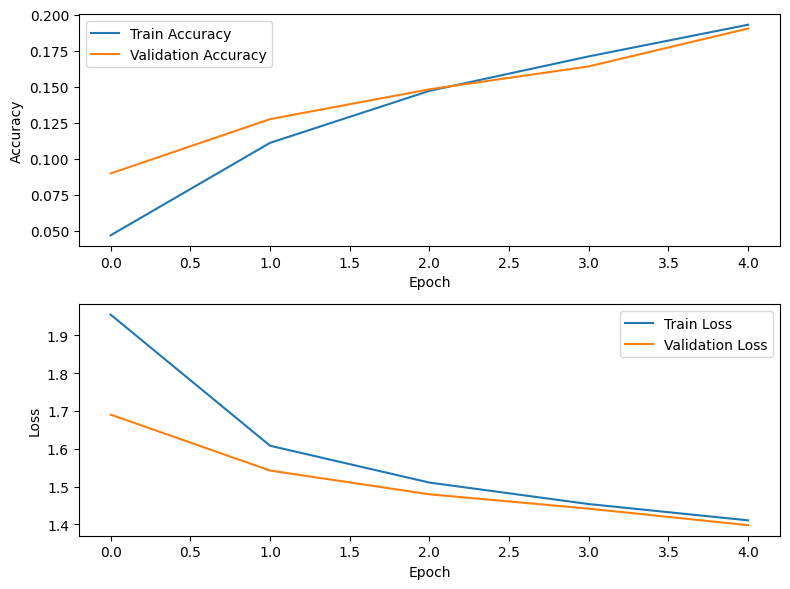

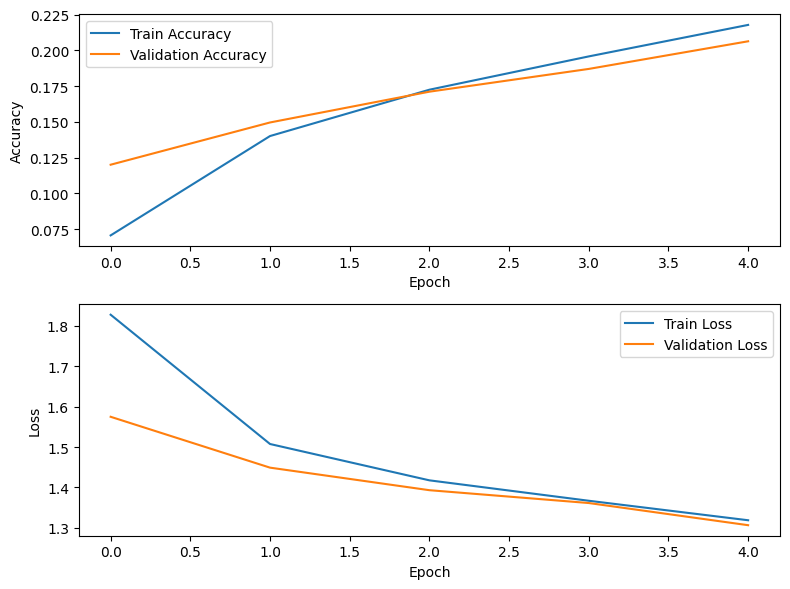

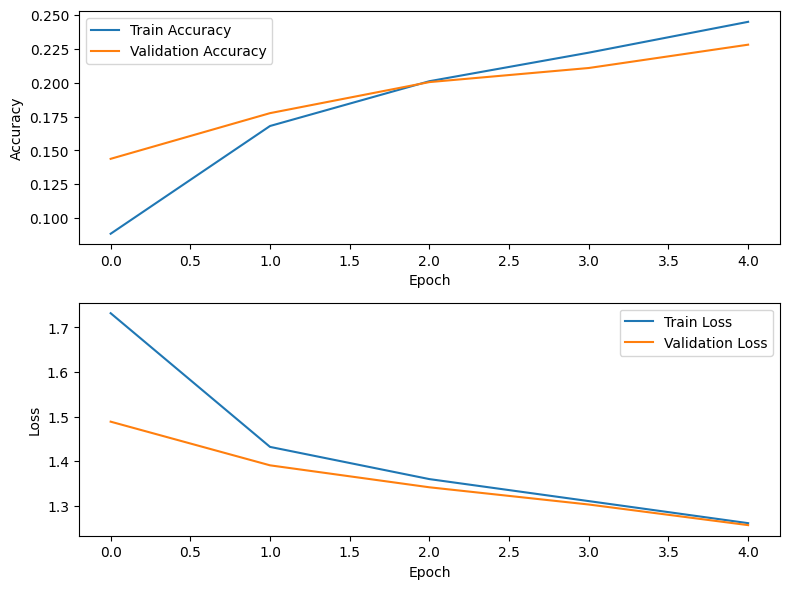

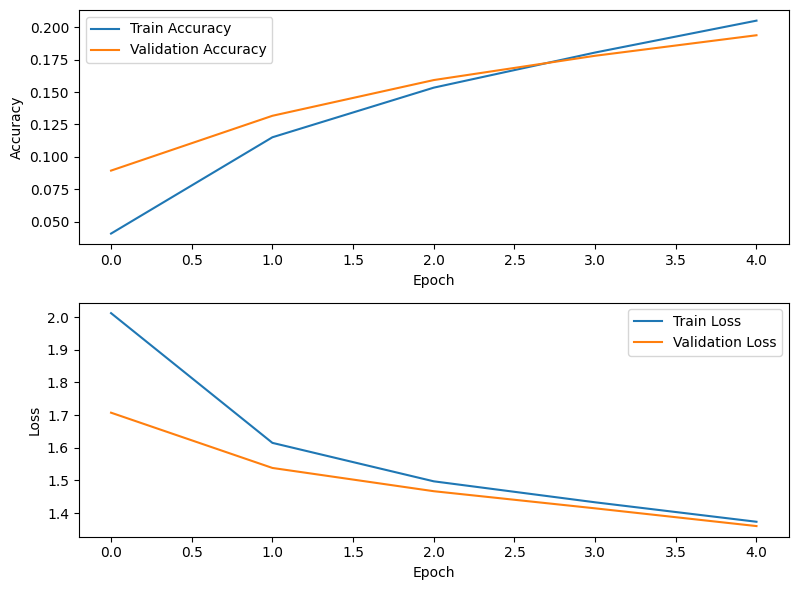

/*-----------------------------*/
/*         iteration 1        */
/*----------------------------*/
   * Select parent for crossing:
       - Selection --------------- 100%
   * Offspring:
       - Crossover:
           mask : [0, 0, 0, 1]
       - Crossover:
           mask : [0, 0, 0, 1]
       - Performing KD on the children :
------------------------------ Training 1 ---------------------------------
Epoch 0/4
----------
train Loss: 1.5145 Acc: 0.1426
val Loss: 1.3624 Acc: 0.1830

Epoch 1/4
----------
train Loss: 1.3074 Acc: 0.2159
val Loss: 1.2993 Acc: 0.2100

Epoch 2/4
----------
train Loss: 1.2424 Acc: 0.2484
val Loss: 1.2349 Acc: 0.2371

Epoch 3/4
----------
train Loss: 1.1939 Acc: 0.2741
val Loss: 1.2075 Acc: 0.2463

Epoch 4/4
----------
train Loss: 1.1513 Acc: 0.2976
val Loss: 1.1737 Acc: 0.2551

Training complete in 10m 55s
Best val Acc: 0.255100
------------------------------ Training 2 ---------------------------------
Epoch 0/4
----------
train Loss: 1.5403 Acc: 0.1265
va

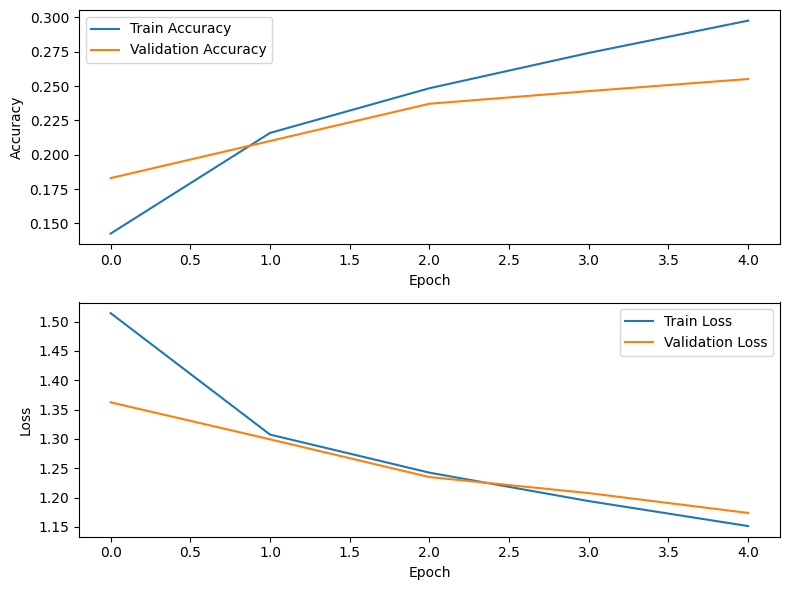

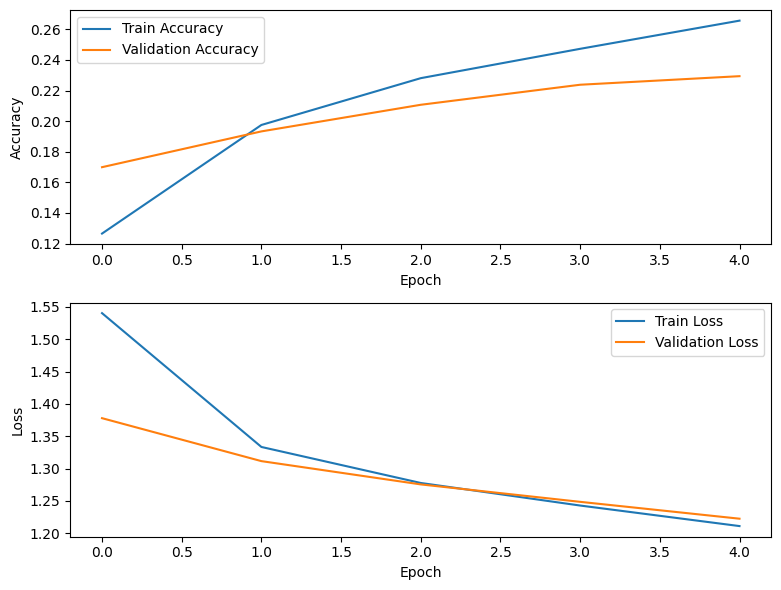

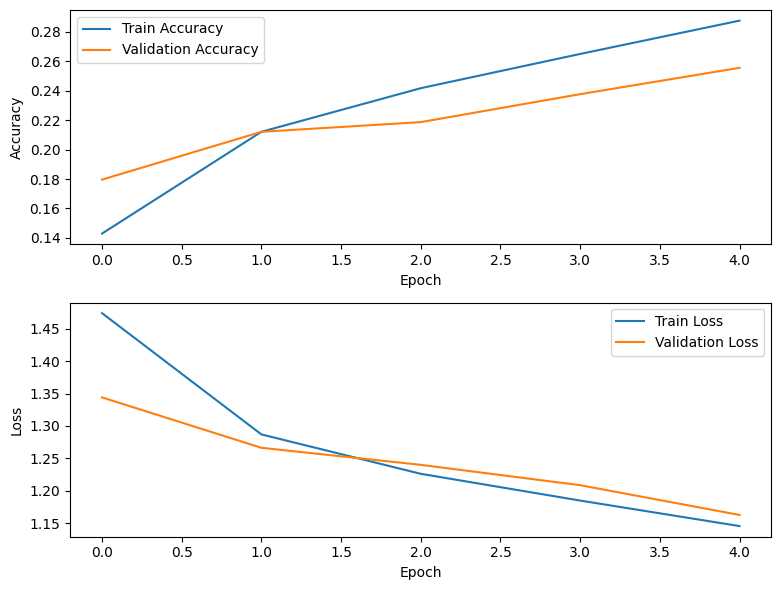

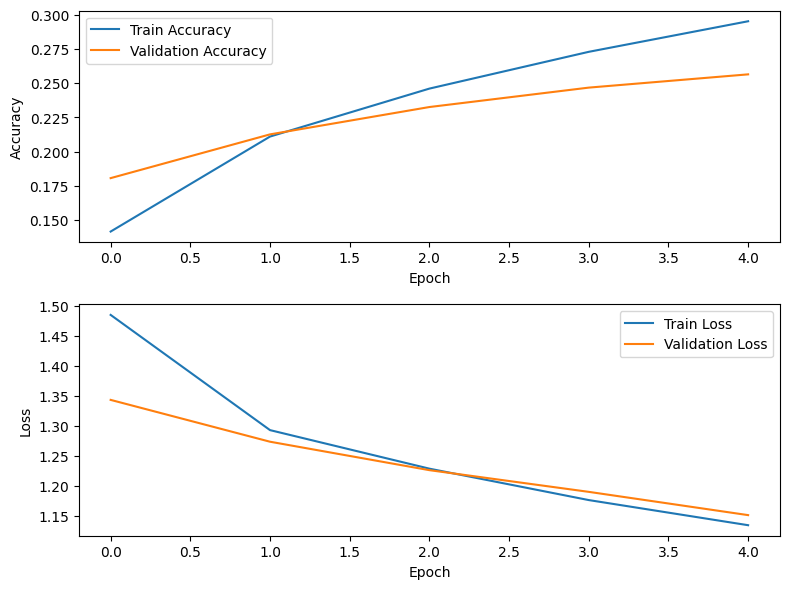

/*-----------------------------*/
/*         iteration 2        */
/*----------------------------*/
   * Select parent for crossing:
       - Selection --------------- 100%
   * Offspring:
       - Crossover:
           mask : [1, 1, 0, 0]
       - Crossover:
           mask : [0, 0, 1, 0]
       - Performing KD on the children :
------------------------------ Training 1 ---------------------------------
Epoch 0/4
----------
train Loss: 1.2147 Acc: 0.2693
val Loss: 1.2205 Acc: 0.2351

Epoch 1/4
----------
train Loss: 1.1607 Acc: 0.2921
val Loss: 1.1827 Acc: 0.2473

Epoch 2/4
----------
train Loss: 1.1262 Acc: 0.3084
val Loss: 1.1523 Acc: 0.2549

Epoch 3/4
----------
train Loss: 1.1033 Acc: 0.3210
val Loss: 1.1410 Acc: 0.2578

Epoch 4/4
----------
train Loss: 1.0858 Acc: 0.3326
val Loss: 1.1344 Acc: 0.2672

Training complete in 11m 4s
Best val Acc: 0.267200
------------------------------ Training 2 ---------------------------------
Epoch 0/4
----------
train Loss: 1.3112 Acc: 0.2255
val

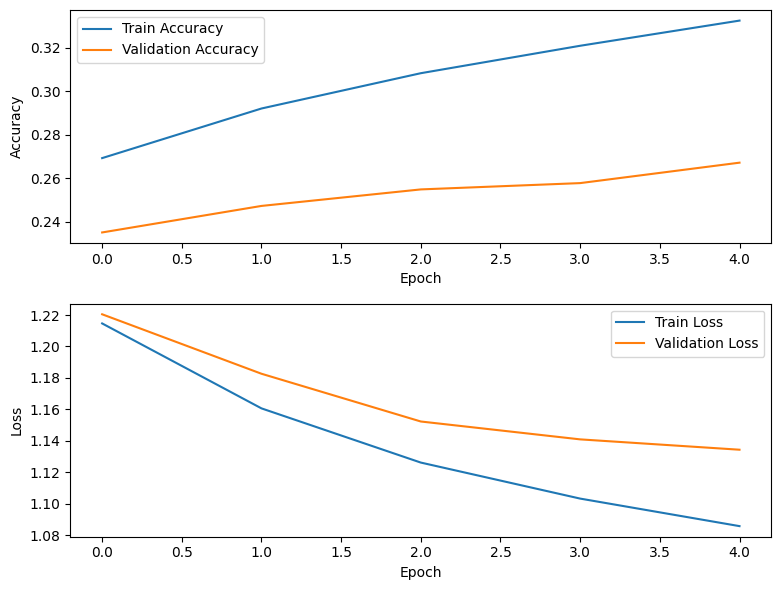

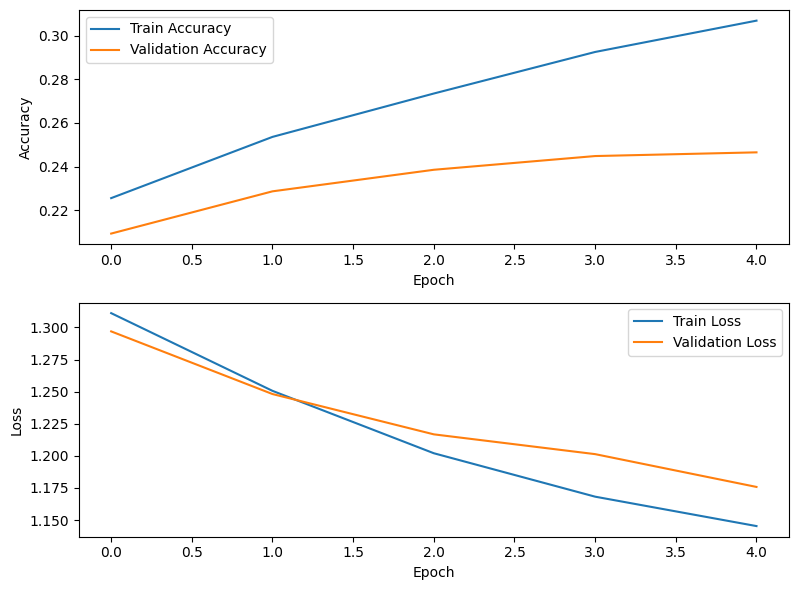

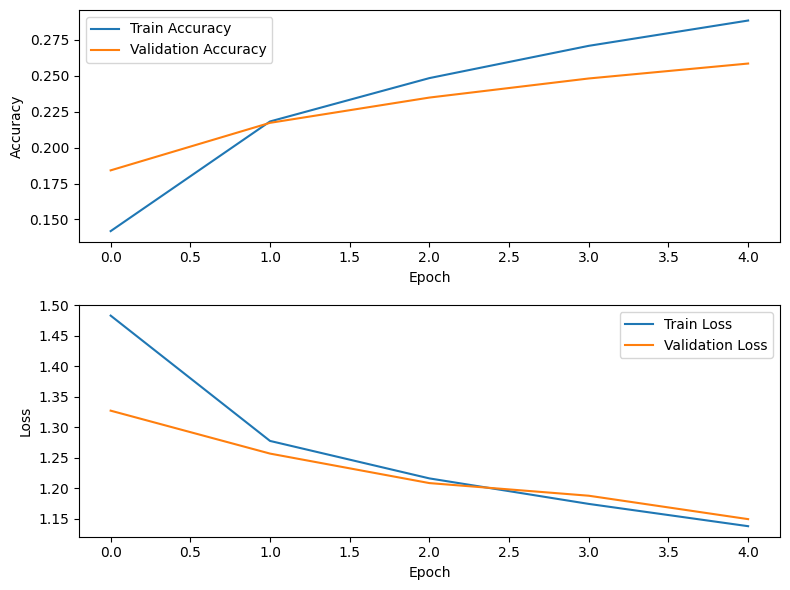

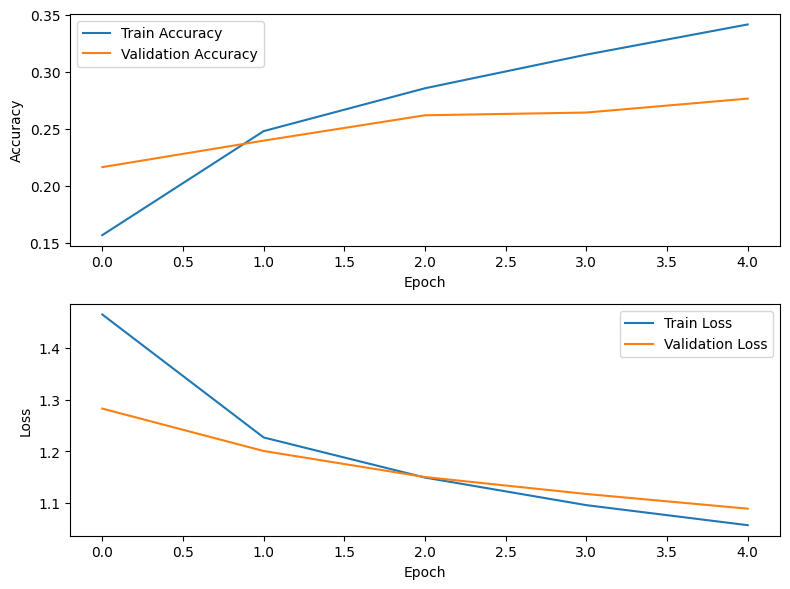

Select the winning ticket from final population
  - Selection --------------- 100%


In [ ]:
winning_ticket = AG.AG_method(model_base, save_to, nb_itr = 2, N = 8 ,pruning_rate = 0.85, pruning_space = 0.05,kd_epoch = 5)

## Evaluate the winning ticket

In [ ]:
save_to = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Cifar-100/SimpleCNN/'
winning_ticket = torch.load( save_to + 'winning_ticket')

In [ ]:
AG.calculate_sparsity(winning_ticket)

tensor(0.8763, device='cuda:0')

In [ ]:
AG.evaluation_2(winning_ticket, nn.CrossEntropyLoss())

Accuracy: 24.65%
Loss: 3.0573


(0.2465, 3.057333581766505)

In [ ]:
data = AG.dataloaders['val']
for in_ , lbl in data:
  in_ = in_.to(AG.device)
  lbl = lbl.to(AG.device)
  out = winning_ticket(in_)
  _, preds = torch.max(out, 1)
  print(preds)
  print('-'*10)
  print(lbl)
  print('-'*10)
  print(preds-lbl)
  break

tensor([19,  8,  3,  7, 13, 87, 51, 68, 37, 54, 55, 89, 91, 24, 60, 95, 13,  7,
        74, 89, 46, 52, 40, 95, 61, 64, 21, 26, 92, 42, 20, 53, 81, 82, 90, 34,
        42, 57, 80, 71,  3, 48, 51, 74, 92, 24, 81, 89, 37,  5, 42, 63, 66, 26,
        51, 74,  5, 70,  2, 12, 42, 20, 63, 84], device='cuda:0')
----------
tensor([88,  8, 55, 21, 13, 39, 35, 68, 90, 25, 84, 19, 86, 24, 60, 30, 16, 24,
        65, 84, 87, 47, 40, 95, 61, 46, 28, 26, 92, 34,  2, 49, 39, 45, 69, 42,
        34, 57, 48, 49, 55, 48, 18,  6, 92, 24, 85,  7, 13, 45, 34,  3,  8, 31,
        26, 74, 57, 43, 35, 97, 42, 24, 33, 84], device='cuda:0')
----------
tensor([-69,   0, -52, -14,   0,  48,  16,   0, -53,  29, -29,  70,   5,   0,
          0,  65,  -3, -17,   9,   5, -41,   5,   0,   0,   0,  18,  -7,   0,
          0,   8,  18,   4,  42,  37,  21,  -8,   8,   0,  32,  22, -52,   0,
         33,  68,   0,   0,  -4,  82,  24, -40,   8,  60,  58,  -5,  25,   0,
        -52,  27, -33, -85,   0,  -4,  30,   0], devic

## Fine-tune the winning ticket

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv  =  optim.SGD(winning_ticket.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)
winning_ticket , statics = train_model(winning_ticket, criterion , optimizer_conv , exp_lr_scheduler , 10)

Epoch 0/9
----------
train Loss: 3.7677 Acc: 0.1250
val Loss: 3.3769 Acc: 0.1987

Epoch 1/9
----------
train Loss: 3.6003 Acc: 0.1544
val Loss: 3.3520 Acc: 0.2034

Epoch 2/9
----------
train Loss: 3.5561 Acc: 0.1607
val Loss: 3.3174 Acc: 0.2091

Epoch 3/9
----------
train Loss: 3.5049 Acc: 0.1709
val Loss: 3.2848 Acc: 0.2164

Epoch 4/9
----------
train Loss: 3.4889 Acc: 0.1763
val Loss: 3.2602 Acc: 0.2151

Epoch 5/9
----------
train Loss: 3.3465 Acc: 0.2021
val Loss: 3.1420 Acc: 0.2462

Epoch 6/9
----------
train Loss: 3.3254 Acc: 0.2087
val Loss: 3.1158 Acc: 0.2552

Epoch 7/9
----------
train Loss: 3.3082 Acc: 0.2113
val Loss: 3.1112 Acc: 0.2549

Epoch 8/9
----------
train Loss: 3.2989 Acc: 0.2107
val Loss: 3.0940 Acc: 0.2575

Epoch 9/9
----------
train Loss: 3.2983 Acc: 0.2156
val Loss: 3.0850 Acc: 0.2607

Training complete in 29m 1s
Best val Acc: 0.260700


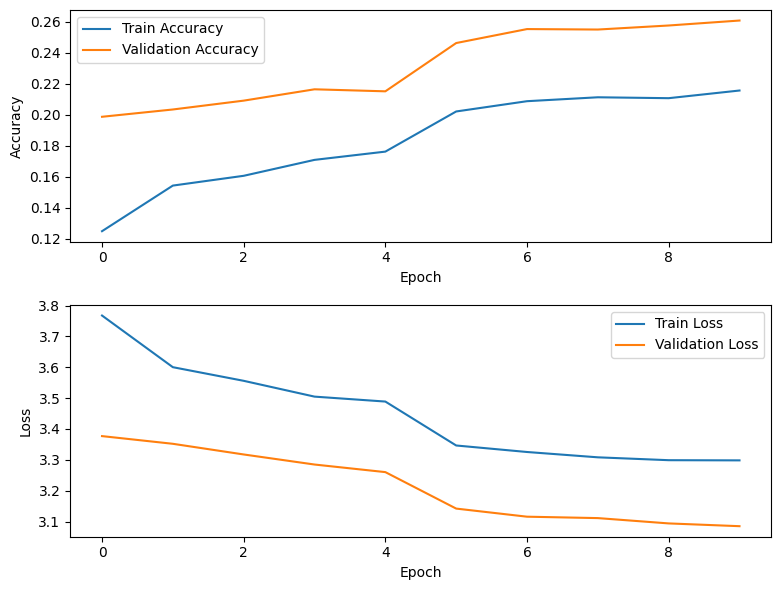

In [ ]:
AG.show_statics_training(statics, save_to + 'winning_ticket fine tuning')
torch.save(winning_ticket, save_to + 'winning_ticket')

In [ ]:
AG.evaluation_2(winning_ticket, nn.CrossEntropyLoss())

Accuracy: 26.07%
Loss: 3.0856


(0.2607, 3.0855768759539175)

## Apply KD on the winning ticket
using Resnet18 model because base model of simplecnn has bad acc

In [5]:
save_to = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Cifar-100/SimpleCNN/'
winning_ticket = torch.load( save_to + 'winning_ticket')

In [6]:
model_path = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Models/Cifar-100/resnet18_cifar_100'
model_base = torch.load(model_path)

In [7]:
AG.evaluation_2(model_base , nn.CrossEntropyLoss())

Accuracy: 80.80%
Loss: 0.6466


(0.808, 0.6466456296717286)

------------------------------ Training ---------------------------------
Epoch 0/14
----------
train Loss: 1.7853 Acc: 0.2769
val Loss: 1.7644 Acc: 0.2540

Epoch 1/14
----------
train Loss: 1.7413 Acc: 0.2877
val Loss: 1.7413 Acc: 0.2696

Epoch 2/14
----------
train Loss: 1.7217 Acc: 0.2963
val Loss: 1.7281 Acc: 0.2662

Epoch 3/14
----------
train Loss: 1.7069 Acc: 0.3043
val Loss: 1.7208 Acc: 0.2664

Epoch 4/14
----------
train Loss: 1.6940 Acc: 0.3133
val Loss: 1.7149 Acc: 0.2734

Epoch 5/14
----------
train Loss: 1.6830 Acc: 0.3214
val Loss: 1.7084 Acc: 0.2747

Epoch 6/14
----------
train Loss: 1.6726 Acc: 0.3293
val Loss: 1.7024 Acc: 0.2800

Epoch 7/14
----------
train Loss: 1.6636 Acc: 0.3348
val Loss: 1.6978 Acc: 0.2826

Epoch 8/14
----------
train Loss: 1.6546 Acc: 0.3433
val Loss: 1.6957 Acc: 0.2819

Epoch 9/14
----------
train Loss: 1.6402 Acc: 0.3609
val Loss: 1.6890 Acc: 0.2855

Epoch 10/14
----------
train Loss: 1.6355 Acc: 0.3634
val Loss: 1.6899 Acc: 0.2874

Epoch 11/14


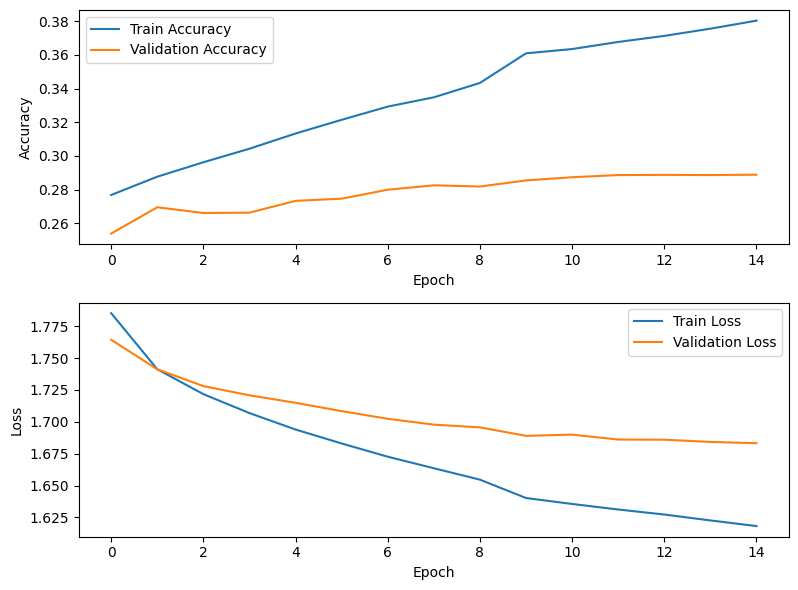

In [8]:
criterion = AG.SoftHardTargetLoss(global_param.soft_citerion,global_param.hard_citerion, global_param.soft_purcntg, global_param.hard_purcntg)

optimizer_conv =  optim.SGD(winning_ticket.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler =  lr_scheduler.StepLR(optimizer_conv, step_size=9, gamma=0.5)

print("------------------------------ Training ---------------------------------")
# Train the model
winning_ticket, statics = AG.train_model_kd_mix(winning_ticket,model_base, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=15)
AG.show_statics_training(statics, save_to + 'winning_ticket KD')
torch.save(winning_ticket, save_to + 'winning_ticket')

In [9]:
AG.evaluation_2(winning_ticket, nn.CrossEntropyLoss())

Accuracy: 28.89%
Loss: 2.9165


(0.2889, 2.916511108920832)